In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import math
import keras

In [2]:
data_df = pd.read_csv("fc_kp.csv")
data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,kp_index_x3
0,2016-01-01 00:00:00,5.512677,-2.305265,-13.208849,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.000
1,2016-01-01 00:00:00,5.512677,-2.305265,-13.208849,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.000
2,2016-01-01 03:00:00,3.152941,-0.440106,-12.515978,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.333
3,2016-01-01 03:00:00,3.152941,-0.440106,-12.515978,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.333
4,2016-01-01 06:00:00,3.226364,-5.161290,-8.537423,143.819967,103.094027,126.3402,129.49592,124.643217,96.82823,...,131.601167,151.2143,144.231933,129.541733,147.492067,156.671133,137.356233,158.362867,144.435267,5.000


In [3]:
len(data_df)

22424

In [4]:
df_filled = data_df.fillna(method='ffill').fillna(method='bfill')


In [5]:
#plotting function
def plot_col(df, start_date, end_date):
    # Filter rows between the desired dates

    filtered_data = df[(df['0'] >= start_date) & (df['0'] <= end_date)]

    # Plotting
    num_cols = 4  # number of graphs in each row
    num_rows = -(-len(filtered_data.columns[1:]) // num_cols)  # Calculate number of rows required

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows*4))
    for i, col in enumerate(filtered_data.columns[1:], 1):  # start from the 2nd column as 1st column is 'date'
        ax = axes[(i-1) // num_cols][(i-1) % num_cols]
        ax.scatter(filtered_data['kp_index_x3'], filtered_data[col])
        ax.set_title(f'kp_index_x3 vs. {col}')
        ax.set_xlabel('kp_index_x3')
        ax.set_ylabel(col)

    # Remove any unused subplots
    for j in range(i, num_cols * num_rows):
        fig.delaxes(axes.flatten()[j])

    plt.tight_layout()
    plt.show()

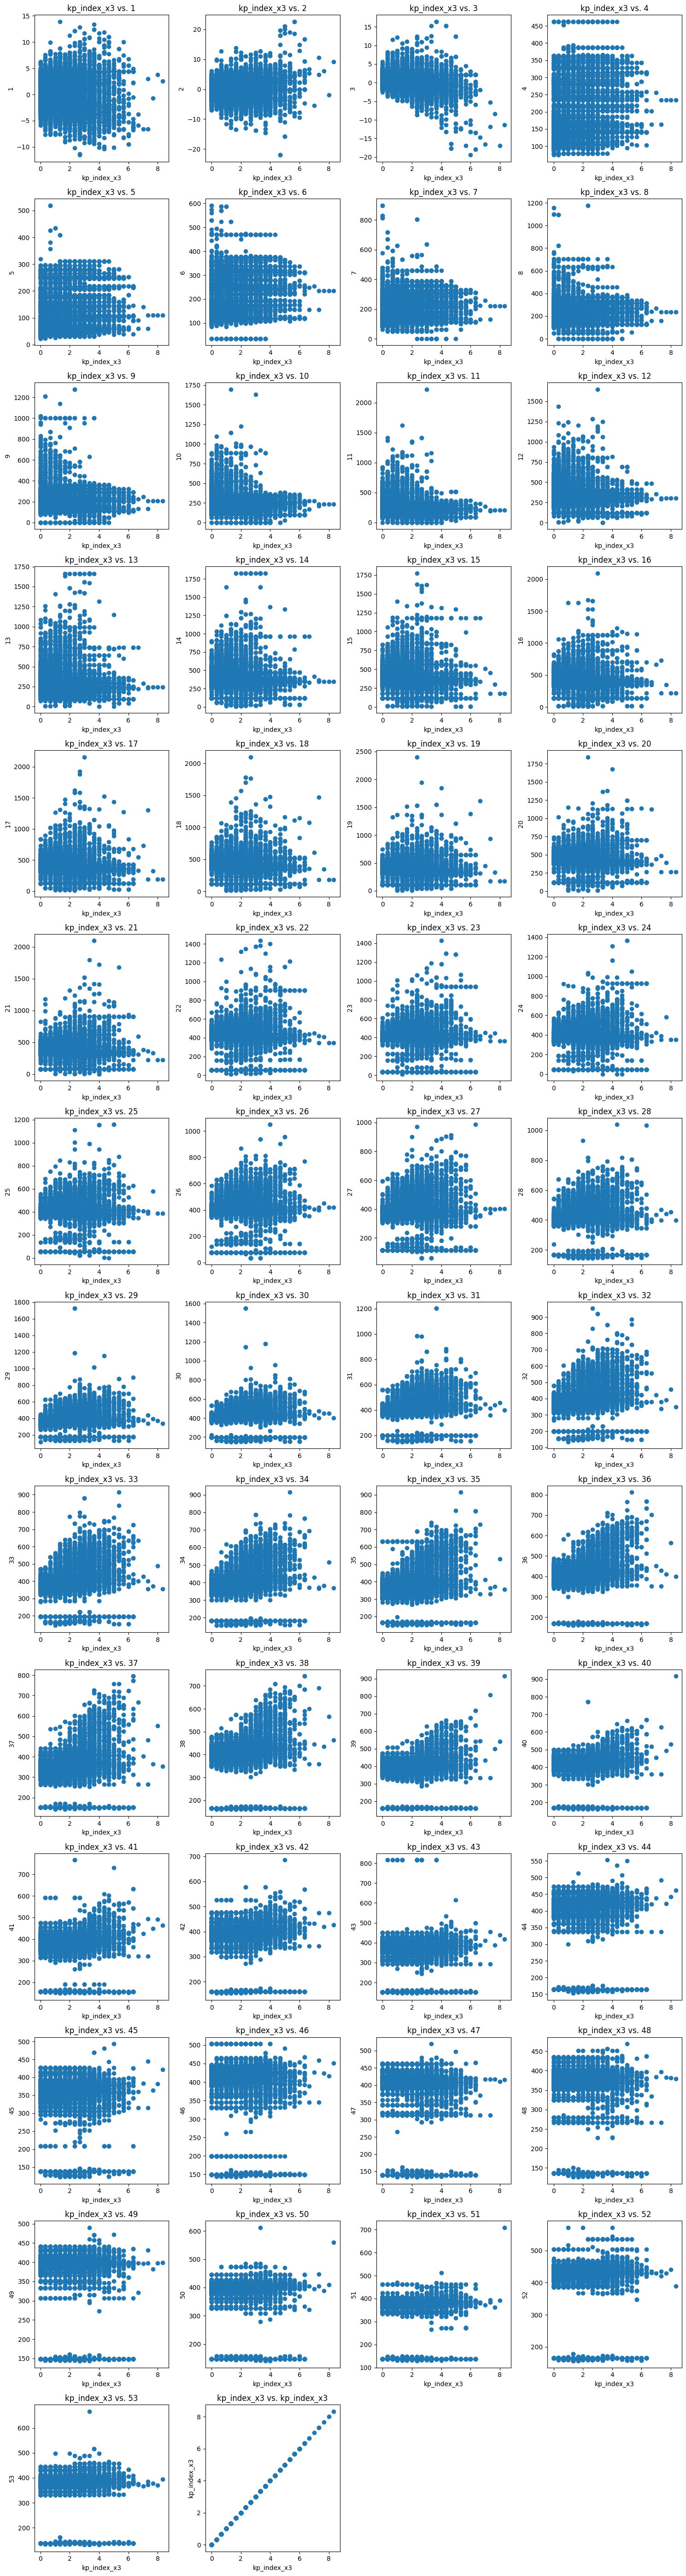

In [6]:
start_date = '2016-01-01 00:00:00'
end_date = '2019-06-27 21:00:00'
plot_col(df_filled, start_date, end_date)

In [7]:
val_test = df_filled['kp_index_x3'].values

In [8]:
len(val_test)

22424

In [9]:
from statsmodels.tsa.stattools import adfuller
ADF_result = adfuller(val_test)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -18.68448936549563
p-value: 2.0410001143894618e-30


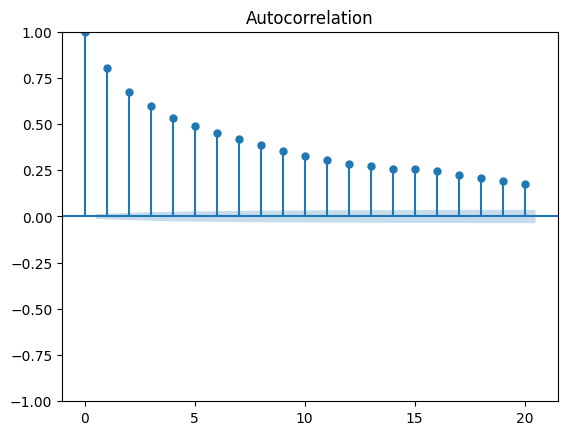

In [10]:
#therefore its stationary data
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(val_test, lags=20);

In [11]:
diff_close = np.diff(val_test, n=1)
val_result = adfuller(diff_close)
print(f'ADF Statistic: {val_result[0]}')
print(f'p-value: {val_result[1]}')


ADF Statistic: -32.84698264235385
p-value: 0.0


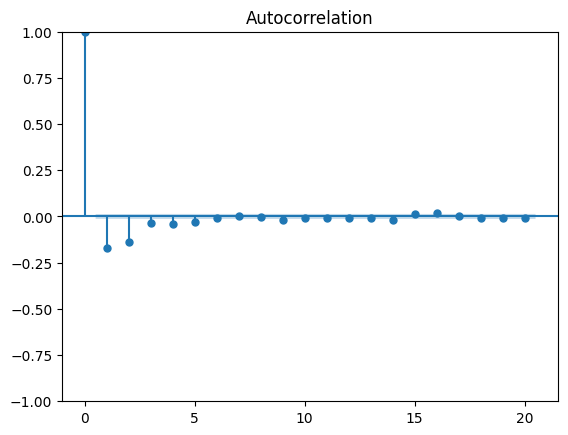

In [12]:
plot_acf(diff_close, lags=20);

In [13]:
import keras
import keras.layers as layers

In [14]:
def root_mean_squared_error(y_true, y_pred):
    return keras.backend.sqrt(keras.backend.mean(keras.backend.square(y_pred - y_true)))

def build_model(input_shape=(53,)):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2), # Helps prevent overfitting
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dense(1) # No activation for regression. For binary classification, use 'sigmoid'
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss=root_mean_squared_error,
                  metrics=[root_mean_squared_error, 'mae']) # Mean absolute error as a metric. For binary classification, you could use 'accuracy'

    return model

# Build and summarize the model
model_nn = build_model()
model_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               6912      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2

In [15]:
X = df_filled.iloc[:, 1:-1].values
y = df_filled.iloc[:, -1].values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

# Standardize the data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=50, # Number of epochs with no improvement after which training will be stopped
                               verbose=1,
                               restore_best_weights=True) # Restore model weights from the epoch with the best value of the monitored quantity

# Define a learning rate schedule function
def lr_schedule(epoch):
    if epoch < 100:
        return 0.01
    elif epoch < 200:
        return 0.001
    else:
        return 0.0001

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

history = model_nn.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=500,
    batch_size=128,
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/500
123/123 [==============================] - 2s 7ms/step - loss: 1.0627 - root_mean_squared_error: 1.0623 - mae: 0.7961 - val_loss: 0.9235 - val_root_mean_squared_error: 0.9242 - val_mae: 0.7280 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.01.
Epoch 2/500
123/123 [==============================] - 1s 7ms/step - loss: 0.9491 - root_mean_squared_error: 0.9489 - mae: 0.7360 - val_loss: 0.8978 - val_root_mean_squared_error: 0.8991 - val_mae: 0.6890 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.01.
Epoch 3/500
123/123 [==============================] - 1s 7ms/step - loss: 0.9081 - root_mean_squared_error: 0.9083 - mae: 0.7014 - val_loss: 0.8669 - val_root_mean_squared_error: 0.8680 - val_mae: 0.6743 - lr: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.01.
Epoch 4/500
123/123 [==============================] - 1s 8ms/step - loss: 0.9106 - root_mean_

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [18]:
trainX = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
testX = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [19]:
trainX.shape

(15696, 1, 53)

In [20]:
testX.shape

(6728, 1, 53)

In [21]:
model = Sequential()
model.add(LSTM(64, input_shape=(1, 53)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, y_train, epochs=50, batch_size=64, verbose=2)

Epoch 1/50
246/246 - 3s - loss: 1.1983 - 3s/epoch - 13ms/step
Epoch 2/50
246/246 - 1s - loss: 0.7640 - 858ms/epoch - 3ms/step
Epoch 3/50
246/246 - 1s - loss: 0.7081 - 731ms/epoch - 3ms/step
Epoch 4/50
246/246 - 1s - loss: 0.6768 - 1s/epoch - 5ms/step
Epoch 5/50
246/246 - 1s - loss: 0.6522 - 1s/epoch - 4ms/step
Epoch 6/50
246/246 - 1s - loss: 0.6421 - 1s/epoch - 4ms/step
Epoch 7/50
246/246 - 1s - loss: 0.6307 - 861ms/epoch - 4ms/step
Epoch 8/50
246/246 - 1s - loss: 0.6226 - 801ms/epoch - 3ms/step
Epoch 9/50
246/246 - 1s - loss: 0.6131 - 803ms/epoch - 3ms/step
Epoch 10/50
246/246 - 1s - loss: 0.6076 - 703ms/epoch - 3ms/step
Epoch 11/50
246/246 - 1s - loss: 0.6032 - 818ms/epoch - 3ms/step
Epoch 12/50
246/246 - 1s - loss: 0.5975 - 837ms/epoch - 3ms/step
Epoch 13/50
246/246 - 1s - loss: 0.5931 - 813ms/epoch - 3ms/step
Epoch 14/50
246/246 - 1s - loss: 0.5896 - 758ms/epoch - 3ms/step
Epoch 15/50
246/246 - 1s - loss: 0.5829 - 797ms/epoch - 3ms/step
Epoch 16/50
246/246 - 1s - loss: 0.5812 - 696

In [22]:
print(model.metrics)

In [23]:
y_pred = model.predict(testX)

211/211 [==============================] - 1s 2ms/step


In [24]:
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse:.2f}")

rmse = math.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

r_squared = r2_score(y_test, y_pred)
print(f"R-squared (R2): {r_squared:.2f}")


Mean Absolute Error (MAE): 0.60
Mean Squared Error (MSE): 0.63
Root Mean Squared Error (RMSE): 0.79
R-squared (R2): 0.60


In [25]:
pred_y_nn = model_nn.predict(X_test)

211/211 [==============================] - 0s 2ms/step


In [26]:
pred_list_nn = [i[0] for i in pred_y_nn]


In [27]:
actual = list(y_test)


In [28]:
for (x,y) in zip(actual, pred_list_nn):
  print("Actual: ", x, "\t\tPredicted ",y)

Streaming output truncated to the last 5000 lines.
Actual:  1.0 		Predicted  1.2925787
Actual:  0.667 		Predicted  1.0589695
Actual:  0.667 		Predicted  2.6406105
Actual:  3.333 		Predicted  1.8912078
Actual:  0.333 		Predicted  0.825583
Actual:  3.333 		Predicted  1.8912078
Actual:  1.333 		Predicted  2.2506442
Actual:  1.667 		Predicted  1.8912078
Actual:  0.667 		Predicted  1.125139
Actual:  0.333 		Predicted  0.6713017
Actual:  2.333 		Predicted  2.9562995
Actual:  2.0 		Predicted  1.4070873
Actual:  4.667 		Predicted  1.8912078
Actual:  3.667 		Predicted  2.8050578
Actual:  1.0 		Predicted  1.0262333
Actual:  2.333 		Predicted  0.9723153
Actual:  5.0 		Predicted  4.3557096
Actual:  1.333 		Predicted  1.8912078
Actual:  1.0 		Predicted  1.4090596
Actual:  1.0 		Predicted  1.3160726
Actual:  4.0 		Predicted  5.574755
Actual:  3.0 		Predicted  2.1014538
Actual:  3.0 		Predicted  1.7121847
Actual:  0.0 		Predicted  1.069344
Actual:  2.333 		Predicted  1.4428759
Actual:  1.333 		Predic

In [29]:
pred_y_lstm = model.predict(testX)

211/211 [==============================] - 1s 6ms/step


In [30]:
pred_list_lstm = [i[0] for i in pred_y_lstm]


In [31]:
for (x,y) in zip(actual, pred_list_lstm):
  print("Actual: ", x, "\t\tPredicted_lstm ",y)

Streaming output truncated to the last 5000 lines.
Actual:  1.0 		Predicted_lstm  1.0421449
Actual:  0.667 		Predicted_lstm  1.2150784
Actual:  0.667 		Predicted_lstm  2.368084
Actual:  3.333 		Predicted_lstm  1.8139943
Actual:  0.333 		Predicted_lstm  0.9650688
Actual:  3.333 		Predicted_lstm  2.4716356
Actual:  1.333 		Predicted_lstm  1.9177843
Actual:  1.667 		Predicted_lstm  1.9200205
Actual:  0.667 		Predicted_lstm  1.2127045
Actual:  0.333 		Predicted_lstm  0.6572484
Actual:  2.333 		Predicted_lstm  3.0830097
Actual:  2.0 		Predicted_lstm  1.3216752
Actual:  4.667 		Predicted_lstm  1.8139943
Actual:  3.667 		Predicted_lstm  2.2531788
Actual:  1.0 		Predicted_lstm  1.3726574
Actual:  2.333 		Predicted_lstm  1.6114649
Actual:  5.0 		Predicted_lstm  4.341292
Actual:  1.333 		Predicted_lstm  1.8139943
Actual:  1.0 		Predicted_lstm  1.394415
Actual:  1.0 		Predicted_lstm  1.1564281
Actual:  4.0 		Predicted_lstm  3.6710348
Actual:  3.0 		Predicted_lstm  2.0359945
Actual:  3.0 		Predict

In [32]:
#saving simple neural network model
model_nn.save('model_neural_network.h5')  # Saves the entire model (architecture, optimizer, and learned weights)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [33]:
model.save('model_lstm.h5')  # Saves the entire model (architecture, optimizer, and learned weights)
